# Exploratory Data Analysis

## ODK 99 - Inventario de Sitio (DG) / Inventario de Sitio RAN

## Descripción

Analizaremos los datos de la fuente **ODK 99** que corresponde al inventario de los elementos en sitio de 
red de acceso de radio y DG.

#### Conectando al Datalake

In [1]:
import os
os.environ['JAVA_HOME'] = '/usr/java/jdk1.8.0_162'
os.environ['SPARK_HOME'] = '/opt/cloudera/parcels/CDH-6.2.0-1.cdh6.2.0.p0.967373/lib/spark'
import findspark
findspark.init()
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import HiveContext

In [2]:
conf = SparkConf().setAppName('EDA_ODK_99')  \
    .setMaster('yarn').set("spark.yarn.queue","root.eda")
spark = SparkSession.builder.config(conf=conf).getOrCreate()
sc = spark.sparkContext
sqlContext = HiveContext(sc)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import re
import pandasql
import folium
from folium import plugins


import nltk
from nltk.probability import FreqDist
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

#from pyspark.sql.functions import udf ,col
#from pyspark.sql.types import IntegerType,StringType

%matplotlib inline

from bokeh.io import show, output_notebook, output_file 
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
from bokeh.palettes import Category20_11, Category20c_20, Category10_5,Category10_6, Category20_20, Plasma256
output_notebook()

/opt/cloudera/parcels/Anaconda-5.3.1/lib/python2.7/site-packages/folium/__init__.py:59: UserWarning: This version of folium is the last to support Python 2. Transition to Python 3 to be able to receive updates and fixes. Check out https://python3statement.org/ for more info.
  UserWarning
/opt/cloudera/parcels/Anaconda-5.3.1/lib/python2.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Loading BokehJS ...

### 1. Recolección de los datos: 

Se crea el dataframe de spark con el universo de datos crudos.  

Los datos se van a recolectar de la tabla ```rci_network_db.tx_stg_tabla_columnar_odk_99``` obtenida previamente en el notebook *ODK_99*.

In [4]:
df_load = spark.sql("SELECT a.*, b.status as status_id, meta_started, meta_finished, meta_device_id, meta_user, id_site, cve_vendor, geo_lon, geo_lat, geo_alt, geo_acc, orig_site_code, orig_cve_vendor, comments, created_on, updated_on FROM rci_network_db.tx_stg_tabla_columnar_odk_99 a LEFT JOIN inventario.raw_panda_eform_site b ON  a.id_form = b.id AND a.cve_type = b.cve_type WHERE b.status NOT IN ('CN', 'AR', 'PE')")

In [5]:
df_load = df_load.toPandas()

In [6]:
df_load.head(10)

,cve_type,id_form,groups,key_dad,Elemento,Activo,Altura,Altura_del_Rack,Ancho,Azimuth,...,cve_vendor,geo_lon,geo_lat,geo_alt,geo_acc,orig_site_code,orig_cve_vendor,comments,created_on,updated_on
0,SINV,184242,id:root:groupStruct-0:groupTwelement-4,root,RFA,00493991,32.500,,,24.000,...,HWI,-99.143916,19.424428,2256.0,14.0,ATT-HMEX0566,HWI,Torre en buen estado,2019-09-18 16:43:47.243,2019-09-18 16:55:22.227
1,SINV,184242,id:root:groupStruct-0:groupTwelement-19,root,RFA,00493990,32.500,,,139.000,...,HWI,-99.143916,19.424428,2256.0,14.0,ATT-HMEX0566,HWI,Torre en buen estado,2019-09-18 16:43:47.243,2019-09-18 16:55:22.227
2,SINV,184242,id:root:groupShelter-0:groupPowerdc-1,root,REC,3G065697,,,,,...,HWI,-99.143916,19.424428,2256.0,14.0,ATT-HMEX0566,HWI,Torre en buen estado,2019-09-18 16:43:47.243,2019-09-18 16:55:22.227
3,SINV,184242,id:root:groupShelter-0:groupSbbank-2:groupSbat...,root,Bateria,No cuenta con activo fijó,,,,,...,HWI,-99.143916,19.424428,2256.0,14.0,ATT-HMEX0566,HWI,Torre en buen estado,2019-09-18 16:43:47.243,2019-09-18 16:55:22.227
4,SINV,184242,id:root:groupStruct-0:groupTwelement-3,root,ODU,3G091092,26.200,,,395.000,...,HWI,-99.143916,19.424428,2256.0,14.0,ATT-HMEX0566,HWI,Torre en buen estado,2019-09-18 16:43:47.243,2019-09-18 16:55:22.227
5,SINV,184242,id:root:groupShelter-0:groupSbbank-6:groupSbat...,root,Bateria,No cuenta con activo fijó,,,,,...,HWI,-99.143916,19.424428,2256.0,14.0,ATT-HMEX0566,HWI,Torre en buen estado,2019-09-18 16:43:47.243,2019-09-18 16:55:22.227
6,SINV,184242,id:root:groupShelter-0:groupSrack-0:groupIrack-9,EQUIPO EN RACK-9,CARD,00629548,,,,,...,HWI,-99.143916,19.424428,2256.0,14.0,ATT-HMEX0566,HWI,Torre en buen estado,2019-09-18 16:43:47.243,2019-09-18 16:55:22.227
7,SINV,184242,id:root:groupShelter-0:groupSbbank-4:groupSbat...,root,Bateria,No cuenta con activo fijó,,,,,...,HWI,-99.143916,19.424428,2256.0,14.0,ATT-HMEX0566,HWI,Torre en buen estado,2019-09-18 16:43:47.243,2019-09-18 16:55:22.227
8,SINV,184242,id:root:groupStruct-0:groupTwelement-15,root,RET,No cuenta con activo fijo,32.500,,,139.000,...,HWI,-99.143916,19.424428,2256.0,14.0,ATT-HMEX0566,HWI,Torre en buen estado,2019-09-18 16:43:47.243,2019-09-18 16:55:22.227
9,SINV,184242,id:root:groupStruct-0,Estructura-0,Estructura,,12.000,,,,...,HWI,-99.143916,19.424428,2256.0,14.0,ATT-HMEX0566,HWI,Torre en buen estado,2019-09-18 16:43:47.243,2019-09-18 16:55:22.227


Para las fuentes de los ODK's nos interesa conocer todos los elementos en sitio, por lo que haremos una limpieza en los campos que contengan características de los mismos.

En la consulta anterior se obtiene la tabla columnar del ODK 99 haciendo un JOIN con la tabla raw_panda_eform_site para obtener el estatus en el que se encuentra cada id_form.

### Una muestra del ODK 32:

In [102]:
df=df_load.copy()
df.head(5)

,cve_type,id_form,groups,key_dad,Elemento,Activo,Altura,Altura_del_Rack,Ancho,Azimuth,...,cve_vendor,geo_lon,geo_lat,geo_alt,geo_acc,orig_site_code,orig_cve_vendor,comments,created_on,updated_on
0,SINV,184242,id:root:groupStruct-0:groupTwelement-4,root,RFA,00493991,32.500,,,24.000,...,HWI,-99.143916,19.424428,2256.0,14.0,ATT-HMEX0566,HWI,Torre en buen estado,2019-09-18 16:43:47.243,2019-09-18 16:55:22.227
1,SINV,184242,id:root:groupStruct-0:groupTwelement-19,root,RFA,00493990,32.500,,,139.000,...,HWI,-99.143916,19.424428,2256.0,14.0,ATT-HMEX0566,HWI,Torre en buen estado,2019-09-18 16:43:47.243,2019-09-18 16:55:22.227
2,SINV,184242,id:root:groupShelter-0:groupPowerdc-1,root,REC,3G065697,,,,,...,HWI,-99.143916,19.424428,2256.0,14.0,ATT-HMEX0566,HWI,Torre en buen estado,2019-09-18 16:43:47.243,2019-09-18 16:55:22.227
3,SINV,184242,id:root:groupShelter-0:groupSbbank-2:groupSbat...,root,Bateria,No cuenta con activo fijó,,,,,...,HWI,-99.143916,19.424428,2256.0,14.0,ATT-HMEX0566,HWI,Torre en buen estado,2019-09-18 16:43:47.243,2019-09-18 16:55:22.227
4,SINV,184242,id:root:groupStruct-0:groupTwelement-3,root,ODU,3G091092,26.200,,,395.000,...,HWI,-99.143916,19.424428,2256.0,14.0,ATT-HMEX0566,HWI,Torre en buen estado,2019-09-18 16:43:47.243,2019-09-18 16:55:22.227


### 2. Descripción de las fuentes.
En este apartado se hará una descripción a detalle de las fuentes para una mejor comprensión de los datos. Por cada fuente se mostrarán los tipos de datos, tamaño de la fuente, es decir, su dimensionalidad y una estadística descriptiva, en ese orden.

In [8]:
print 'renglones = ',df.shape[0],' columnas = ',df.shape[1]

renglones =  60514  columnas =  75


#### Breve descripción de los campos

El dataframe que se estará usando para la presentación del EDA, esta conformado por la unión de dos tablas, la fuente principal ```rci_network_db.tx_stg_tabla_columnar_odk_99``` de la cual se obtienen las siguientes columnas:

**clave_form**: Clave de identificación del ODK.  
**id_form**: Número de formulario.  
**form_element**: Jerarquía del registro.  
**key_dad**: Grupo padre al que pertenece el registro.  
**Elemento**: Tipo de elemento al que pertenece el registro.  
**filedate**: Fecha de la partición que se esta utilizando.  
**year**: Año de la partición que se esta utilizando.  
**month**: Mes de la partición que se esta utilizando.  
**day**: Día de la partición que se esta utilizando.  
**meta_date_marked_as_complete**: Fecha en la que se completo el odk.  
**Activo**: Número de activo fijo (manual o escaner).  
**Altura**: Altura de la torre.  
**Altura_del_Rack**: Altura del rack.  
**Ancho**: Ancho de la torre.  
**Azimuth**: Medida azimuth.  
**Bancos_de_baterias**: Cantidad de los bancos de baterias que existen.  
**Capacidad**: *Por definir*.  
**Codigo_de_Sitio**: Código de sitio donde se realiza el leventamiento del odk.  
**Elabora_Reporte**: Nombre de la persona que elaboro el formulario.  
**Enviar_acuse_a**: Correo electrónico de la persona que recibe el formulario.  
**Equipos_Adicionales?**: *Por definir*.  
**Firma**: Imagen de la firma de la persona que lleno el formulario.  
**Gabinetes_en_Sitio**: Cantidad de gabinetes en el sitio.  
**Generadores_en_Sitio**: Afirmación o Negación sobre si hay o no generadores en sitio.  
**Largo**: Largo de la torre.  
**Marca**: Marca del elemento de red.  
**Modelo**: Modelo del elemento de red.  
**Nombre_del_Proveedor**: Proveedor en el sitio.  
**Pierna_de_la_Torre**: *Por definir*.  
**Proyecto**: Proyecto al que pertenece el formulario.  
**Racks**: Cantida de racks en sitio.  
**Sector**: Sector del sitio al que se hace inventario.  
**Serie**: Número de serie (manual o escaner).  
**Shelters_en_Sitio**: Número de shelters en sitio.  
**Status**: Estatus físico en el que se encuentra el elemento de red.  
**TS_Finalizacion**: Fecha en la que se finalizo el formulario.  
**Tipo_Cerradura**: Tipo de cerradura.  
**Tipo_Equipo**: Tipo de equipo al que se le hace inventario.  
**Tipo_Shelter**: Tipo de shelter en sitio.  
**Tipo_de_Base**: Tipo de base.  
**Tipo_de_Cerradura**: Tipo de cerradura.  
**Tipo_de_Contenedores**: Tipo de contenedores.  
**Tipo_de_Instalacion**: Tipo de instalacipon.  
**Tipo_de_Pierna**: Tipo de pierna.  
**Tipo_de_Proteccion**: Tipo de protección.  
**Tipo_de_Soporte**: Tipo de soporte.  
**Tipo_de_estructura**: Tipo de estructura del sitio.  
**Tipo_de_inventario**: Tipo de Inventario.  
**Tipo_elemento**: Tipo de elemento de red.  
**Ubicacion**: *Por definir*.  
**Unidades_de_Rack**: *Por definir*.  
**Uso_de_Gabinete**: *Por definir*.  
**Vista_Activo_Fijo**: Imagen.  
**Vista_Banco_Baterias**:  Imagen.  
**Vista_Etiqueta_SN**: Imagen.  
**Vista_Frontal_del_Rack**: Imagen.  
**Vista_Gabinete_Frontal**: Imagen.  
**Vista_Gabinete_Trasera**: Imagen.  
**Vista_Numero_Serie**: Imagen.  
**Vista_Shelter_Frontal**: Imagen.  
**Vista_Shelter_Pasamuros_exterior**: Imagen.  
**Vista_Trasera_del_Rack**: Imagen.  
**Vista__de_la_estructura**: Imagen.  
**Vista_de_espacio_banco_de_baterias**: Imagen.  
**Vista_del_elemento**: Imagen.  
**torres_o_estructuras**: *Por definir*.  

La segunda fuente es el catálogo ```inventario.raw_panda_eform_site```, el cual contiene el status de los formularios, códigos de sitios, logitud, latitud y fechas importantes para el análisis.  
De esta fuente se tomán las siguientes columnas:

**status_id**: Estatus en el que se encuentra el formulario.  
**meta_started**: La fecha en la que se abrio el formulario para ser llenado.  
**meta_finished**: La fecha en la que se termino de llenar el formulario.  
**meta_device_id**: *Por definir*.  
**meta_user**: *Por definir*.  
**id_site**: Id del sitio.  
**cve_vendor**: Clave del proveedor.  
**geo_lon**: Longitud (coordenada del sitio).  
**geo_lat**: Latitud (coordenada del sitio). 
**geo_alt**: *Por definir*.  
**geo_acc**: *Por definir*.  
**orig_site_code**: Código de sitio.  
**orig_cve_vendor**: Clave del proveedor.  
**comments**: Comentarios informativos sobre el odk o el estatus.  
**created_on**: Fecha de creación del formulario.  
**updated_on**: Fecha de actualización del formulario. 

Esta segunda fuente es importante ya que nos dice en que estatus se encuentra el odk y los mantiene actualizados.

### 3. Exploración de los datos.

Entraremos en mas profundidad a los datos que existen en el odk 99 y se realizarán limpiezas si los datos así lo requieren.

Las claves que contiene la tabla del odk 99 son:

In [9]:
claves = pd.unique(df['cve_type']).tolist()
claves

[u'SINV']

**SINV**: Inventario de Sitio (DG)  
**SINR**:  Inventario de Sitio RAN

Conteo por clave form:

In [10]:
conteo = pandasql.sqldf("SELECT COUNT(*) as conteo, cve_type from df GROUP BY cve_type;", locals())
conteo

,conteo,cve_type
0,60514,SINV


A continuación, se muestra una lista de todos los elementos en sitio que se identificaron durante la adquisición:

In [11]:
elementos = pd.unique(df['Elemento']).tolist()
elementos

[u'RFA',
 u'REC',
 u'Bateria',
 u'ODU',
 u'CARD',
 u'RET',
 u'Estructura',
 u'root',
 u'IDU',
 u'RRU',
 u'Rack',
 u'POWP',
 u'OTH',
 u'Banco de baterias',
 u'shelter',
 u'MWC',
 u'BBU',
 u'ACE',
 u'PD',
 u'SWI',
 u'Gabinete',
 u'MWA',
 u'GEN',
 u'P3',
 u'PDI',
 u'ROU',
 u'DES',
 u'ACS',
 u'BOARD',
 u'LIGH',
 u'TRAN']

Algunos elementos son claramente identificables como: *Gabinete* o *Bateria* y otros están representados por una abreviatura de 3 o mas letras.

A continuación se muestra la frecuencia de los elementos que existen:

In [12]:
Freq_Elementos=pd.DataFrame(df.Elemento.value_counts())
Freq_Elementos

,Elemento
Gabinete,16058
Bateria,8925
Banco de baterias,6072
CARD,5828
RRU,4887
RFA,3213
RET,3183
OTH,2694
ODU,1925
REC,1104


Text(0.5,0,'Elementos')

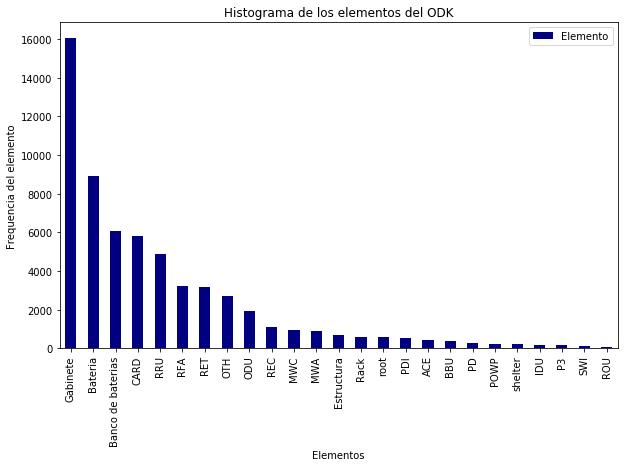

In [13]:
Freq_Elementos[:25].plot(kind='bar',figsize=(10,6),rot=90,colormap='jet')

plt.title('Histograma de los elementos del ODK')
plt.ylabel('Frequencia del elemento')
plt.xlabel('Elementos')

Podemos observar que el elemento Gabinete es el elemento que se encuentra mas frecuente en el inventario.

Obtenemos también la distribución de estatus de los distintos formularios.

,status_id
AC,86.399841
OR,7.226427
RJ,5.696203
RE,0.677529


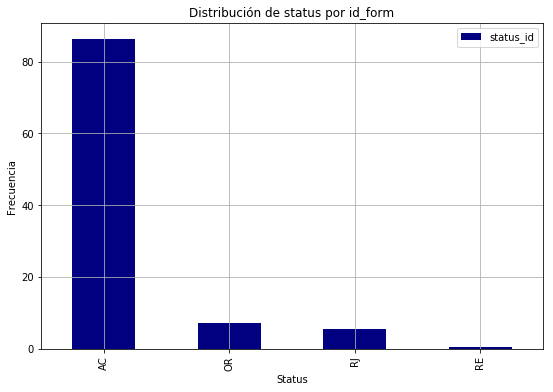

In [14]:
Freq_status=pd.DataFrame((df.status_id.value_counts()/df.status_id.value_counts().sum())*100)
Freq_status.plot(kind='bar',grid=True,figsize=(9,6),colormap='jet')
plt.title(u'Distribución de status por id_form')
plt.ylabel(u'Frecuencia')
plt.xlabel(u'Status')

Freq_status

El estatus en el que se encuentra el 85% de los formularios es aceptado.

Antes de realizar la limpieza, se separaran las columnas serie y activo para el calculo de indicadores. Esto se requiere hacer debido a la forma en la que se adquirieron los datos, los espacios en blanco no representan activos no trazables, estos registros están vacíos porque en donde hay datos es en otra columna de dataframe. A este dataframe también se le hará la limpieza igual que al dataframe general.

In [103]:
df_kpi = df[['Serie','Activo']]
df_kpi.head(5)

,Serie,Activo
0,15CN102650712,00493991
1,15CN102650716,00493990
2,011101217671R483200C10,3G065697
3,No cuenta con número de serie,No cuenta con activo fijó
4,215241248910BB000512,3G091092


Siguiendo con la exploración de los datos, tenemos el campo de **serie** y **activo**, a continuación una muestra:

In [104]:
df.Serie.head(20).tolist()

[u'15CN102650712',
 u'15CN102650716',
 u'011101217671R483200C10',
 u'No cuenta con n\xfamero de serie',
 u'215241248910BB000512',
 u'No cuenta con n\xfamero de serie',
 u'2102319897D0F6022730',
 u'No cuenta con n\xfamero de serie',
 u'CN10152914848',
 u'',
 u'022HEM6TFB603244',
 u'',
 u'CN10152914837',
 u'No cuenta con n\xfamero de serie',
 u'No cuenta con n\xfamero de serie',
 u'21021132546TB7907691',
 u'No cuenta con n\xfamero de serie',
 u'210305488510DB005367',
 u'2102310SFMBTF7015327',
 u'No cuenta con n\xfamero de serie']

In [105]:
df.Activo.head(20).tolist()

[u'00493991',
 u'00493990',
 u'3G065697',
 u'No cuenta con activo fij\xf3',
 u'3G091092',
 u'No cuenta con activo fij\xf3',
 u'00629548',
 u'No cuenta con activo fij\xf3',
 u'No cuenta con activo fijo',
 u'',
 u'No cuenta con activo fij\xf3',
 u'',
 u'No cuenta con activo fijo',
 u'No cuenta con activo fij\xf3',
 u'No cuenta con activo fij\xf3',
 u'3G091109',
 u'No cuenta con activo fij\xf3',
 u'00699895',
 u'No cuenta con activo fij\xf3',
 u'No cuenta con activo fij\xf3']

Como se puede ver, hay números de serie y activo con datos como *NO VISIBLE* o *Sin etiqueta*, estos datos requieren limpieza para su manipulación, se hará a continuación:

#### Limpieza para homologar los campos de serie y activo:

Se homologan las letras a mayúsculas, se eliminan espacios en blanco (en caso de que haya después o antes de un número de serie o activo), se reemplazan acentos y se cambian espacios en blanco por la palabara *null*.

In [106]:
df.Serie = df.Serie.str.lower()
df.Serie = df.Serie.str.strip()
df.Serie.replace(u'á',u'a',regex=True,inplace=True)
df.Serie.replace(u'é',u'e',regex=True,inplace=True)
df.Serie.replace(u'í',u'i',regex=True,inplace=True)
df.Serie.replace(u'ó',u'o',regex=True,inplace=True)
df.Serie.replace(u'ú',u'u',regex=True,inplace=True)

In [107]:
df.Activo = df.Activo.str.lower()
df.Activo = df.Activo.str.strip()
df.Activo.replace(u'á',u'a',regex=True,inplace=True)
df.Activo.replace(u'é',u'e',regex=True,inplace=True)
df.Activo.replace(u'í',u'i',regex=True,inplace=True)
df.Activo.replace(u'ó',u'o',regex=True,inplace=True)
df.Activo.replace(u'ú',u'u',regex=True,inplace=True)

In [108]:
df_kpi.Serie = df_kpi.Serie.str.lower()
df_kpi.Serie = df_kpi.Serie.str.strip()
df_kpi.Serie.replace(u'á',u'a',regex=True,inplace=True)
df_kpi.Serie.replace(u'é',u'e',regex=True,inplace=True)
df_kpi.Serie.replace(u'í',u'i',regex=True,inplace=True)
df_kpi.Serie.replace(u'ó',u'o',regex=True,inplace=True)
df_kpi.Serie.replace(u'ú',u'u',regex=True,inplace=True)

In [109]:
df_kpi.Activo = df_kpi.Activo.str.lower()
df_kpi.Activo = df_kpi.Activo.str.strip()
df_kpi.Activo.replace(u'á',u'a',regex=True,inplace=True)
df_kpi.Activo.replace(u'é',u'e',regex=True,inplace=True)
df_kpi.Activo.replace(u'í',u'i',regex=True,inplace=True)
df_kpi.Activo.replace(u'ó',u'o',regex=True,inplace=True)
df_kpi.Activo.replace(u'ú',u'u',regex=True,inplace=True)

De el dataframe **df_kpi** solamente traeremos los registros donde la longitud de la serie o la longitud de el activo sea mayor a 0, esto descarta los registros vacíos que no representan ningún elemento.

In [110]:
df_kpi_aux = pandasql.sqldf("SELECT * from df_kpi WHERE length(serie) > 0 OR length(activo) > 0;", locals())
df_kpi_aux.head(5)

,Serie,Activo
0,15cn102650712,00493991
1,15cn102650716,00493990
2,011101217671r483200c10,3g065697
3,no cuenta con numero de serie,no cuenta con activo fijo
4,215241248910bb000512,3g091092


#### Hacemos más limpieza para poder eliminar basura.
Esta limpieza se sigue tomando del catálogo que se encuentra en Hive *regex_cat_cleanup* y adicional, se aregan a la lista campos que salieron de acuerdo al análisis.

In [93]:
dirt=['no visible', 'sin etiqueta', 'ni visible', 'n/v','nv','ilegible','n/a', 's/a', 'na','no legible', 'no cuenta con activo fijo',
      'n/v deteriorado','sin activo fijo','no vicible','no hay','no tiene','no visble',
      'no viaible', '.fhy', 'bxfj', 'cambiar la foto', 'hdjdjjdjfjfj', 'hdjrnnfjfjf', 'hffhthjih', 'hhyhigch',
      'hswkwjj', 'no aplica', 'no pude borrar elemnto', 'ns no visible', 'sin serie', 'sitio ibs no aplica', 'tutj',
      'uflp serie no visible', 'xxxxxxx', 'hsid# djdncg', 'sin informacion disponible', 'no tiene numero de serie',
      'hdkoe kg udkke' 'no se ve', 'ninguna', 'no tiene etiqueta y no se alcnaza a ver.', 'fue un error',
      'no legible', 'sin etiqueta', 'no disponible', 'no tiene', 'sin datos', 'num de serie no legible', 'etiqueta no legible', 'no cuenta con numero de serie',
      'no aplica por error se selecciona una tarjeta mas', 'enviado ya en reporte anterior', 'hlk', 'ninguno', 'la antena no tiene etiqueta por lo tanto tampoco numero de serie', 'no leguible',
      'sin targeta (por equivocacion se agrego este eslot 18 )', 'no cuenta con numeros de serie', 'enviados en reporte anterior .', 'sin etiqueta de numero de serie',
      'sin numero', 'sin informacion disponible', 'sin acceso a la antena', 'no tiene serie', 'sin acceso', 'no se pudo sacar ya que esta clausurado el sitio',
      'no se hizo por que no tenemos tarjeta se las llevo el ing de huawei gabriel lopez', 'sin informacion disponible', 'no aplica ta este segmento',
      'sin numero de serie visible', 'enviada en reporte  anterior', 'no hay antena', 'no se pudo sacar ya que esta clausurado y nos sacaron de sitio',
      'sin serie falta etiqueta', 'sin numero de serie no cuenta con la etiqueta', 'no tiene etiqueta', 'no existe', 'no serie visible', 'no hay bbu esta en resguardo por el ing gabriel lopez',
      'no legible', 'na', 'na hay  tarjeta', 'sin acceso al numero de serie', 'no visibles', 'uelp serie no visible', 'sin informacion disponible', 'sin tarjeta', 'fue un error de dedo no ay mas slot',
      'codigo no visible', 'num de serie no visible', 'sin informacion', 'no se aprecia el codigo', 'sin numero de serie', 'no trae la etiketa de numero de serie',
      'no aplica.', 'no se pudo sacar el numero  de serie ya q nos sacaron del sitio ya q esta clausurado', 'no tiene serie visible', 'no tiene serial ala vista',
      'no se tiene acceso a la antena', 'etiqueta no visible', 'no se puede tomar la foto porque tenemos la fan', 'n/a  no se instalan antenas', 'no aplica sitio ibs',
      'sin numero', 'kcuvicuv', 'error no hay mas', 'no se puede apreciar el codigo', 'no aplica es ibs.', 'no  cuenta con etiquetas de n/s', 'esta ultima no vale',
      'no hay tarjeta', 'esta no vale', 'falta']

In [112]:
df.Serie.replace(dirt,np.NaN,regex=True,inplace=True)

In [114]:
df.Activo.replace(dirt,np.NaN,regex=True,inplace=True)

In [115]:
df_kpi_aux.replace(dirt,"NULL",regex=True,inplace=True)

Después de la limpieza, se pueden observar los campos de Serie y Activos limpios:

In [113]:
df.Serie.head(20)

0              15cn102650712
1              15cn102650716
2     011101217671r483200c10
3                        NaN
4       215241248910bb000512
5                        NaN
6       2102319897d0f6022730
7                        NaN
8              cn10152914848
9                           
10          022hem6tfb603244
11                          
12             cn10152914837
13                       NaN
14                       NaN
15      21021132546tb7907691
16                       NaN
17      210305488510db005367
18      2102310sfmbtf7015327
19                       NaN
Name: Serie, dtype: object

In [116]:
df.Activo.head(20)

0     00493991
1     00493990
2     3g065697
3          NaN
4     3g091092
5          NaN
6     00629548
7          NaN
8          NaN
9             
10         NaN
11            
12         NaN
13         NaN
14         NaN
15    3g091109
16         NaN
17    00699895
18         NaN
19         NaN
Name: Activo, dtype: object

In [117]:
df_kpi_aux.head(20)

,Serie,Activo
0,15cn102650712,00493991
1,15cn102650716,00493990
2,011101217671r483200c10,3g065697
3,NULL,NULL
4,215241248910bb000512,3g091092
5,NULL,NULL
6,2102319897d0f6022730,00629548
7,NULL,NULL
8,cn10152914848,NULL
9,022hem6tfb603244,NULL


Además de la limpieza en los campos principales que nos ayudarán con la trazabilidad de los elementos de red, podemos encontrar catálogos dentro del ODK 99, a continuación se muestra la limpieza de los campos para los catálogos que se mostrarán en el apartado **5. Catálogos**:

### Limpieza Campo Marca

In [30]:
df_marca = pandasql.sqldf("SELECT DISTINCT upper(trim(marca)) as marca FROM df WHERE marca not like '%|%' AND length(marca) != 0 AND marca != 'OTH';", locals())
df_marca.head(10)

,marca
0,CMAN
1,COMMS
2,EMRSN
3,HWI
4,MEI
5,CISCO
6,NEC
7,STAHLIN
8,HUAWEI
9,HUEB


Retiramos del catálogo los siguientes registros que no son una marca

In [31]:
limpieza_marca = pandasql.sqldf("SELECT DISTINCT marca FROM df_marca WHERE lower(marca) like 'no %' OR lower(marca) like 'sin %';", locals())
limpieza_marca

,marca
0,NO VISIBLE
1,NO TIENE


In [32]:
dirt = [limpieza_marca]
df_marca.replace(dirt,'',regex=True,inplace=True)

Para obtener el nombre de la marca, cargamos la tabla ```inventario.raw_panda_vendor```

In [33]:
df_vendor = spark.sql("SELECT DISTINCT upper(trim(cve_vendor)) cve_vendor, vendor_name FROM inventario.raw_panda_vendor").cache().toPandas()
df_vendor.head(10)

,cve_vendor,vendor_name
0,MIDIT,Miditel
1,WNSM,WNSMEXICO SA DE CV
2,AGLNT,Agilent Technologies
3,ATM,Atelcom
4,COMDE,Comde
5,ATELI,ATELIER K&V
6,GZ-N,Guzman-Nasich
7,INSMX,Instalación Maxima en Tecnologia
8,TXSRG,Telextorage SA
9,PCI01,Prefabricados y Construcciones Industriales S.A


Se hace la unión a la tabla ```inventario.raw_panda_vendor``` usando cve_vendor y marca

In [34]:
cat_marca = pandasql.sqldf("SELECT marca, CASE WHEN vendor_name IS NULL THEN 'Por Definir' ELSE vendor_name END 'descripcion_marca' FROM (SELECT marca, vendor_name FROM df_marca LEFT JOIN df_vendor ON marca = cve_vendor WHERE marca != '')a", locals())
cat_marca.head(10)

,marca,descripcion_marca
0,CMAN,Andrew
1,COMMS,Commscope
2,EMRSN,Emerson
3,HWI,Huawei
4,MEI,MEXICANA DE ELECTRONICA INDUSTRIAL SA DE CV
5,CISCO,Cisco
6,NEC,Nec Mexico
7,STAHLIN,Por Definir
8,HUAWEI,Por Definir
9,HUEB,HUEBBELL


### Limpieza catálogo Elemento - Marca - Modelo

In [35]:
df_modelo_marca = pandasql.sqldf("SELECT DISTINCT lower(trim(elemento)) as elemento, upper(trim(marca)) as marca, upper(trim(modelo)) as modelo FROM df WHERE modelo not like '%|%' AND length(modelo) != 0 AND modelo != 'OTH' AND marca not like '%|%' AND length(marca) != 0 AND marca != 'OTH';", locals())
df_modelo_marca.head(10)

,elemento,marca,modelo
0,rfa,CMAN,DBXLH-6565EC-A2M
1,rfa,COMMS,DBXLH-6565EC-A2M
2,rec,EMRSN,R48-3200
3,odu,HWI,XMC 23G-2
4,card,HWI,UPEUC
5,ret,COMMS,ATM2OO-A20
6,card,HWI,UBBPD6
7,card,HWI,PIU
8,idu,HWI,RTN 910
9,card,HWI,UMPTB1


Retiramos del catálogo los siguientes registros que no son un modelo o una marca

In [36]:
limpieza_modelo = pandasql.sqldf("SELECT DISTINCT modelo FROM df_modelo_marca WHERE lower(modelo) like 'no %' OR lower(modelo) like 'sin %';", locals())
limpieza_marca = pandasql.sqldf("SELECT DISTINCT marca FROM df_modelo_marca WHERE lower(marca) like 'no %' OR lower(marca) like 'sin %';", locals())

In [37]:
dirt = [limpieza_modelo, limpieza_marca]
df_modelo_marca.replace(dirt,'',regex=True,inplace=True)

Para el catálogo modelo no se cuenta con alguna tabla previa, así que los registros únicos que se tienen en el campo modelo formarán parte del catálogo:

In [38]:
cat_modelo_marca = pandasql.sqldf("SELECT * FROM df_modelo_marca WHERE modelo != '' AND marca != ''", locals())
cat_modelo_marca.head(10)

,elemento,marca,modelo
0,rfa,CMAN,DBXLH-6565EC-A2M
1,rfa,COMMS,DBXLH-6565EC-A2M
2,rec,EMRSN,R48-3200
3,odu,HWI,XMC 23G-2
4,card,HWI,UPEUC
5,ret,COMMS,ATM2OO-A20
6,card,HWI,UBBPD6
7,card,HWI,PIU
8,idu,HWI,RTN 910
9,card,HWI,UMPTB1


### Tipo de Elemento

El catálogo de tipo de elemento se conforma con los distintos que se tienen en dicho campo, sin contar el root el cual es un default que se le ponen a todos aquellos registros que lo tengan como padre directo.

In [39]:
cat_elemento = pandasql.sqldf("SELECT DISTINCT UPPER(elemento) AS elemento FROM df WHERE elemento != 'root'", locals())
cat_elemento

,elemento
0,RFA
1,REC
2,BATERIA
3,ODU
4,CARD
5,RET
6,ESTRUCTURA
7,IDU
8,RRU
9,RACK


### Limpieza campo proyecto

In [40]:
df_proyecto = pandasql.sqldf("SELECT DISTINCT UPPER(trim(proyecto)) as proyecto FROM df WHERE proyecto not like '%|%' AND length(proyecto) != 0 AND proyecto != 'OTH';", locals())
df_proyecto

,proyecto
0,317E2E
1,DEPLOVR


Podemos observar que solo se tienen 28 proyectos y podemos identificar que los registros como **NO** y **HUAWEI** no son proyectos, así que estos junto con los que solamente tengan 1 número, no serán identificados como proyectos y se quitarán del catálogo.

In [41]:
cat_proyecto = pandasql.sqldf("SELECT proyecto FROM df_proyecto WHERE length(trim(proyecto)) > 1 AND proyecto != 'NO' AND proyecto != 'HUAWEI';", locals())
cat_proyecto

,proyecto
0,317E2E
1,DEPLOVR


### Coordenadas de sitio

Utilizando las coordenadas de latitud y longitud proporcionadas por el catálogo ```inventario.raw_panda_eform_site``` junto con el código de sitio, podemos obtener un mapa con la ubicación donde se ha llevado a cabo inventario perteneciente al odk 99.

In [42]:
cat_ubicacion = pandasql.sqldf("SELECT DISTINCT orig_site_code as site_code, geo_lat as latitude, geo_lon as longitude FROM df;", locals())
cat_ubicacion

,site_code,latitude,longitude
0,ATT-HMEX0566,19.424428,-99.143916
1,ATT-HMEX1060,19.526274,-99.145531
2,DIFMGH1194,19.417597,-99.200032
3,ATT-HMEX0654,19.561957,-99.223175
4,ATT-HMEX0654,19.561896,-99.223144
5,ATT-MEX-9554,19.391322,-99.281997
6,MEXIXP1107,19.322203,-98.875723
7,MEX-9746,19.318073,-99.136943
8,ATT-HMEX1542,19.382742,-99.008296
9,ATT-JAL-5237,20.699498,-103.407303


### 4. Calidad de los datos.

#### Missings Values

Los missings values son los valores faltantes en el conjunto de datos que se refieren a aquellos campos que están vacíos o no tienen valores asignados, estos generalmente ocurren debido a errores de entrada de datos, fallas que ocurren con los procesos de recopilación de datos y, a menudo, al unir varias columnas de diferentes tablas encontramos una condición que conduce a valores faltantes. Existen numerosas formas de tratar los valores perdidos, los más fáciles son reemplazar el valor perdido con la media, la mediana, la moda o un valor constante (llegamos a un valor basado en el conocimiento del dominio) y otra alternativa es eliminar la entrada desde el conjunto de datos en sí.

Para evitar traer columnas que no son relevantes para el calculo de KPIs o catálogos que probbablemente sean vistas, haremos una lista con las columnas de las cuales nos interesa saber su porcentaje, y acontinuación, calculamos el porcentaje de NA's que tiene la fuente por columna:

In [118]:
#Limpieza de registros vacíos
df.replace('',np.NaN,inplace=True)
relevantes=['Activo', 'Serie', 'Bancos_de_baterias', 'Codigo_de_Sitio', 'Marca', 'Modelo',
               'Proyecto', 'Shelters_en_Sitio', 'meta_started', 'meta_finished']

In [119]:
nas=df[relevantes].isna().sum()
porcentaje_nas=nas/df[relevantes].isna().count()

columnas=list(porcentaje_nas.keys())
counts_nas=list(porcentaje_nas.values)

#Para el siguiente comando, en el parámetro "color":
#Dependiendo el número de columnas se escoge un pallete, este debe ser cargado en la sección de librerías,
#Sólo se añade a la parte from bokeh.palettes import Category20c_20  colocando una ","
#http://docs.bokeh.org/en/1.3.2/docs/reference/palettes.html
#Se recomienda no poner más de 20 columnas. 
source=ColumnDataSource(dict(columnas=columnas, counts_nas=counts_nas, color=Category20_20))

p=figure(x_range=columnas, plot_height=300, plot_width=850, y_range=(0,1), title='Porcentaje de NAs por columna')
p.vbar(x='columnas',top='counts_nas',width=.7, color='color', legend='columnas', source=source)

p.xgrid.grid_line_color = None
p.legend.orientation = "horizontal"
p.legend.location = "top_center"

show(p)
pd.DataFrame(porcentaje_nas*100,columns=['Porcentaje de NAs'])

/opt/cloudera/parcels/Anaconda-5.3.1/lib/python2.7/site-packages/bokeh/models/sources.py:110: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('color', 20), ('columnas', 10), ('counts_nas', 10)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))


,Porcentaje de NAs
Activo,55.132697
Serie,37.229401
Bancos_de_baterias,98.175629
Codigo_de_Sitio,99.514162
Marca,2.467198
Modelo,2.467198
Proyecto,98.993621
Shelters_en_Sitio,99.846317
meta_started,0.000000
meta_finished,0.000000


Debido a la estructura del odk y a la manipulación que se hizo previamente para obtener la estructura columnar, podemos ver que las columnas *Banco_de_baterias*, *Codigo_de_Sitio*, *Proyecto*, *Shelters_en_Sitio* y *TS_Finalización* que son columnas que dentro de los formularios aparecian de 1 a 2 veces máximo por id form, tienen mas entre 95% y 99% de valores null.

Podemos observar que columnas como **Activo**, **Serie**, **Marca** y **Modelo** cuentan con un porcentaje menor de campos nulos, lo cual nos interesa mucho ya que, el activo y la serie nos ayudan a sacar indicadores.

Se termina la limpieza de los valores *Nan* o *nulos* en los campos de serie y activo para el cálculo de indicadores.

In [120]:
df.Serie=df.Serie.str.upper()
df.Activo=df.Activo.str.upper()

In [121]:
df.fillna('NULL',inplace=True)

### 5. Catálogos.
Se enlistan los catálogos que surgieron de la exploración. 

#### Catálogo Elemento

In [47]:
cat_elemento.head(10)

,elemento
0,RFA
1,REC
2,BATERIA
3,ODU
4,CARD
5,RET
6,ESTRUCTURA
7,IDU
8,RRU
9,RACK


#### Catálogo Marca

In [48]:
cat_marca.head(10)

,marca,descripcion_marca
0,CMAN,Andrew
1,COMMS,Commscope
2,EMRSN,Emerson
3,HWI,Huawei
4,MEI,MEXICANA DE ELECTRONICA INDUSTRIAL SA DE CV
5,CISCO,Cisco
6,NEC,Nec Mexico
7,STAHLIN,Por Definir
8,HUAWEI,Por Definir
9,HUEB,HUEBBELL


#### Catálogo Marca y Modelo del Elemento

In [49]:
cat_modelo_marca.head(10)

,elemento,marca,modelo
0,rfa,CMAN,DBXLH-6565EC-A2M
1,rfa,COMMS,DBXLH-6565EC-A2M
2,rec,EMRSN,R48-3200
3,odu,HWI,XMC 23G-2
4,card,HWI,UPEUC
5,ret,COMMS,ATM2OO-A20
6,card,HWI,UBBPD6
7,card,HWI,PIU
8,idu,HWI,RTN 910
9,card,HWI,UMPTB1


#### Catálogo Proyecto

In [50]:
cat_proyecto.head(10)

,proyecto
0,317E2E
1,DEPLOVR


#### Ubicación

In [51]:
cat_ubicacion.head(10)

,site_code,latitude,longitude
0,ATT-HMEX0566,19.424428,-99.143916
1,ATT-HMEX1060,19.526274,-99.145531
2,DIFMGH1194,19.417597,-99.200032
3,ATT-HMEX0654,19.561957,-99.223175
4,ATT-HMEX0654,19.561896,-99.223144
5,ATT-MEX-9554,19.391322,-99.281997
6,MEXIXP1107,19.322203,-98.875723
7,MEX-9746,19.318073,-99.136943
8,ATT-HMEX1542,19.382742,-99.008296
9,ATT-JAL-5237,20.699498,-103.407303


### 6. Preparación de los datos.

A continuación se presentan las reglas que se siguieron para realizar la limpieza de los datos. 

#### Reglas utilizadas:
* Se eliminan todos los registros: ('no visible','n/v','nv','ilegible','n/a','na','no legible',
    'n/v deteriorado','sin activo fijo','no vicible','no hay','no tiene',  
    'No visble','no visble','No viaible', etc...).      
* Se pasa upper case todos los atributos (Las columnas **Serie** y **Activo**).
* Se eliminan espacios sobrantes.
* Se reeplazan los strings 'NA'.
* Se eliminan acentos y caracteres '/\'

### 7. Métricas KPI.
Se mostrarán los KPIs generados. 

In [124]:
aux = df.copy()

#### Total de elementos

In [59]:
Total_Elementos=df_kpi_aux.shape[0]
Total_Elementos

52949

#### Total Elementos Trazables

In [60]:
Total_Tr=df_kpi_aux.loc[(df_kpi_aux.Serie!='NULL') | (df_kpi_aux.Activo!='NULL')].shape[0]
Total_Tr

43974

#### Total Elementos NO Trazables

In [61]:
Total_NOTr=Total_Elementos-Total_Tr
Total_NOTr

8975

#### Total Elementos Trazables Únicos

In [63]:
Total_Tr_Unic=df_kpi_aux[['Serie','Activo']].loc[(df_kpi_aux.Serie!='NULL') | (df_kpi_aux.Activo!='NULL')].drop_duplicates().shape[0]
Total_Tr_Unic

39222

#### Total Elementos Trazables Duplicados

In [64]:
Total_Tr_Dupli=Total_Tr-Total_Tr_Unic
Total_Tr_Dupli

4752

#### Total Elementos Trazables Únicos Con Serie Con Activo

In [65]:
Total_Tr_Unic_CS_CA=df_kpi_aux[['Serie','Activo']].loc[(df_kpi_aux.Serie!='NULL') & (df_kpi_aux.Activo!='NULL')].drop_duplicates().shape[0]
Total_Tr_Unic_CS_CA

22186

#### Total Elementos Trazables Únicos Con Serie Sin Activo

In [66]:
Total_Tr_Unic_CS_SA=df_kpi_aux[['Serie','Activo']].loc[(df_kpi_aux.Serie!='NULL') & (df_kpi_aux.Activo=='NULL')].drop_duplicates().shape[0]
Total_Tr_Unic_CS_SA

14220

#### Total Elementos Trazables Únicos Sin Serie Con Activo

In [67]:
Total_Tr_Unic_SS_CA=df_kpi_aux[['Serie','Activo']].loc[(df_kpi_aux.Serie=='NULL') & (df_kpi_aux.Activo!='NULL')].drop_duplicates().shape[0]
Total_Tr_Unic_SS_CA

2816

In [68]:
KPIs=pd.DataFrame({'KPI':['Total Elementos','Total Elementos Trazables',
                         'Total NO Trazables','Total Trazables Unicos',
                         'Total Trazables Duplicados',
                          'Total CS CA','Total CS SA','Total SS CA'],
                  'Resultado':[Total_Elementos,Total_Tr,Total_NOTr,
                              Total_Tr_Unic,Total_Tr_Dupli,
                               Total_Tr_Unic_CS_CA,Total_Tr_Unic_CS_SA,
                              Total_Tr_Unic_SS_CA]})
KPIs

,KPI,Resultado
0,Total Elementos,52949
1,Total Elementos Trazables,43974
2,Total NO Trazables,8975
3,Total Trazables Unicos,39222
4,Total Trazables Duplicados,4752
5,Total CS CA,22186
6,Total CS SA,14220
7,Total SS CA,2816


Se guarda la tabla de eda y kpi

In [69]:
mySchema = StructType([ StructField("cve_type", StringType(), True)\
                       ,StructField("id_form", StringType(), True)\
                       ,StructField("groups", StringType(), True)\
                       ,StructField("key_dad", StringType(), True)\
                       ,StructField("Elemento", StringType(), True)\
                       ,StructField("Activo", StringType(), True)\
                       ,StructField("Altura", StringType(), True)\
                       ,StructField("Altura_del_Rack", StringType(), True)\
                       ,StructField("Ancho", StringType(), True)\
                       ,StructField("Azimuth", StringType(), True)\
                       ,StructField("Bancos_de_baterias", StringType(), True)\
                       ,StructField("Capacidad", StringType(), True)\
                       ,StructField("Codigo_de_Sitio", StringType(), True)\
                       ,StructField("Elabora_Reporte", StringType(), True)\
                       ,StructField("Enviar_acuse_a", StringType(), True)\
                       ,StructField("Equipos_Adicionales?", StringType(), True)\
                       ,StructField("Firma", StringType(), True)\
                       ,StructField("Gabinetes_en_Sitio", StringType(), True)\
                       ,StructField("Generadores_en_Sitio", StringType(), True)\
                       ,StructField("Largo", StringType(), True)\
                       ,StructField("Marca", StringType(), True)\
                       ,StructField("Modelo", StringType(), True)\
                       ,StructField("Pierna_de_la_Torre", StringType(), True)\
                       ,StructField("Proyecto", StringType(), True)\
                       ,StructField("Racks", StringType(), True)\
                       ,StructField("Sector", StringType(), True)\
                       ,StructField("Serie", StringType(), True)\
                       ,StructField("Shelters_en_Sitio", StringType(), True)\
                       ,StructField("Status", StringType(), True)\
                       ,StructField("Tipo_Cerradura", StringType(), True)\
                       ,StructField("Tipo_Equipo", StringType(), True)\
                       ,StructField("Tipo_Shelter", StringType(), True)\
                       ,StructField("Tipo_de_Base", StringType(), True)\
                       ,StructField("Tipo_de_Cerradura", StringType(), True)\
                       ,StructField("Tipo_de_Contenedores", StringType(), True)\
                       ,StructField("Tipo_de_Instalacion", StringType(), True)\
                       ,StructField("Tipo_de_Pierna", StringType(), True)\
                       ,StructField("Tipo_de_Proteccion", StringType(), True)\
                       ,StructField("Tipo_de_Soporte", StringType(), True)\
                       ,StructField("Tipo_de_estructura", StringType(), True)\
                       ,StructField("Tipo_de_inventario", StringType(), True)\
                       ,StructField("Tipo_elemento", StringType(), True)\
                       ,StructField("Ubicacion", StringType(), True)\
                       ,StructField("Unidades_de_Rack", StringType(), True)\
                       ,StructField("Uso_de_Gabinete", StringType(), True)\
                       ,StructField("Vista_Activo_Fijo", StringType(), True)\
                       ,StructField("Vista_Banco_Baterias", StringType(), True)\
                       ,StructField("Vista_Etiqueta_SN", StringType(), True)\
                       ,StructField("Vista_Frontal_del_Rack", StringType(), True)\
                       ,StructField("Vista_Gabinete_Frontal", StringType(), True)\
                       ,StructField("Vista_Gabinete_Trasera", StringType(), True)\
                       ,StructField("Vista_Numero_Serie", StringType(), True)\
                       ,StructField("Vista_Shelter_Frontal", StringType(), True)\
                       ,StructField("Vista_Shelter_Pasamuros_exterior", StringType(), True)\
                       ,StructField("Vista_Trasera_del_Rack", StringType(), True)\
                       ,StructField("Vista__de_la_estructura", StringType(), True)\
                       ,StructField("Vista_de_espacio_banco_de_baterias", StringType(), True)\
                       ,StructField("Vista_del_elemento", StringType(), True)\
                       ,StructField("torres_o_estructuras", StringType(), True)\
                       ,StructField("status_id", StringType(), True)\
                       ,StructField("meta_started", StringType(), True)\
                       ,StructField("meta_finished", StringType(), True)\
                       ,StructField("meta_device_id", StringType(), True)\
                       ,StructField("meta_user", StringType(), True)\
                       ,StructField("id_site", StringType(), True)\
                       ,StructField("cve_vendor", StringType(), True)\
                       ,StructField("geo_lon", StringType(), True)\
                       ,StructField("geo_lat", StringType(), True)\
                       ,StructField("geo_alt", StringType(), True)\
                       ,StructField("geo_acc", StringType(), True)\
                       ,StructField("orig_site_code", StringType(), True)\
                       ,StructField("orig_cve_vendor", StringType(), True)\
                       ,StructField("comments", StringType(), True)\
                       ,StructField("created_on", StringType(), True)\
                       ,StructField("updated_on'", StringType(), True)])

In [70]:
df_hive_eda = spark.createDataFrame(df,schema = mySchema)
df_hive_kpi = spark.createDataFrame(KPIs)

In [71]:
#### Se sube la tabla a Hive
df_hive_eda.write.mode("overwrite").saveAsTable("rci_network_db.eda_odk_99")
df_hive_kpi.write.mode("overwrite").saveAsTable("rci_network_db.kpi_odk_99")